# Data Augmentation

In [1]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Model, optimizers

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.


In [2]:
# READ IN AUDIO FILES 
audio = "/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/"

In [3]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df=pd.read_csv('Uploads/audio.csv',usecols=['emotion','path','gender','actor'])
audio_df.head()

,gender,emotion,actor,path
0,male,surprise,1,/Users/murielkosaka/Desktop/capstone_project/a...
1,male,surprise,1,/Users/murielkosaka/Desktop/capstone_project/a...
2,male,angry,1,/Users/murielkosaka/Desktop/capstone_project/a...
3,male,fear,1,/Users/murielkosaka/Desktop/capstone_project/a...
4,male,fear,1,/Users/murielkosaka/Desktop/capstone_project/a...


In [4]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['gender','actor']])

In [ ]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

## Add Noise, Stretch, Speed and Pitch to Original Audio File

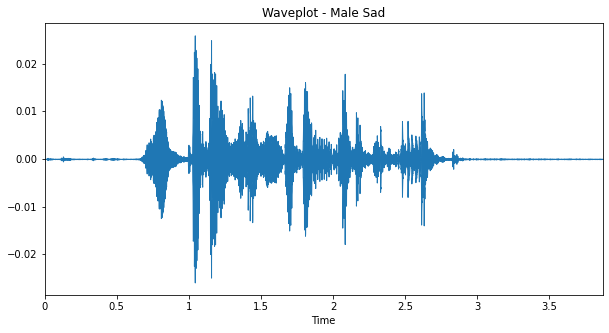

In [14]:
# MALE SAD ORIGINAL AUDIO FILE
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Sad')
plt.savefig('Waveplot_MaleSad.png')


In [6]:
# PLAY AUDIO FILE
librosa.output.write_wav('Uploads/ipd.Audio Files/MaleSadOriginal.wav', x, sr)
Audio(data=x, rate=sr)


In [7]:
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

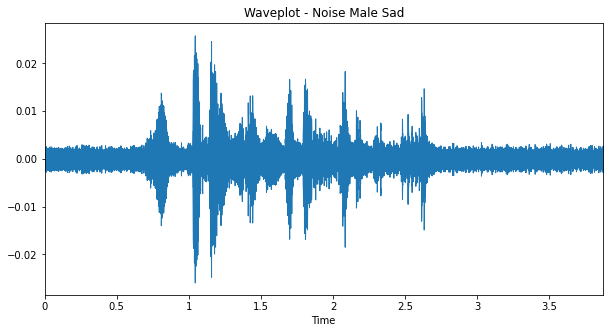

In [8]:
# ADD NOISE TO MALE SAD ORIGINAL AUDIO FILE
x = noise(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Noise Male Sad')
plt.savefig('Waveplot_MaleSadNoise.png')


In [9]:
# PLAY AUDIO FILE
librosa.output.write_wav('Uploads/ipd.Audio Files/MaleSadNoise.wav', x, sr)
Audio(data=x, rate=sr)

In [11]:
# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

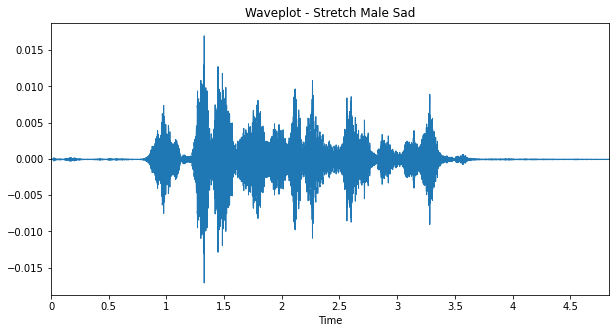

In [12]:
# ADD STRETCH TO MALE SAD ORIGINAL AUDIO FILE
x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')

In [13]:
# PLAY AUDIO FILE
librosa.output.write_wav('Uploads/ipd.Audio Files/MaleSadStretch.wav', x, sr)
Audio(data=x, rate=sr)

In [15]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

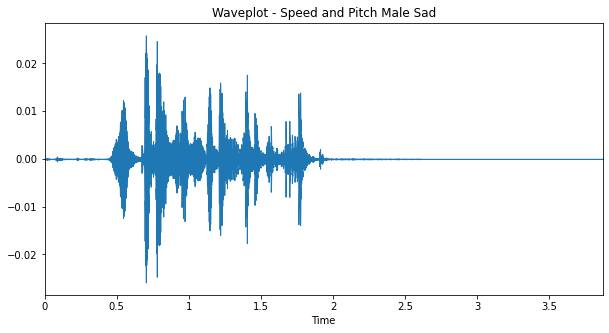

In [16]:
# ADD SPEED AND PITCH TO MALE SAD ORIGINAL AUDIO FILE
x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Sad')
plt.savefig('Waveplot_MaleSadSpeedPitch.png')

In [17]:
# PLAY AUDIO FILE
librosa.output.write_wav('Uploads/ipd.Audio Files/MaleSadSpeedPitch.wav', x, sr)
Audio(data=x, rate=sr)

## Apply Data Augmentation Methods to Train Set

In [18]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1152


,log_spec
0,"[-78.77537, -78.77537, -78.77537, -78.77537, -..."
1,"[-72.616615, -72.09919, -71.89846, -72.148895,..."
2,"[-52.326466, -52.641125, -54.079063, -55.52898..."
3,"[-72.203445, -72.128136, -72.01338, -71.80605,..."
4,"[-75.79316, -75.76318, -75.71961, -76.06954, -..."


In [19]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1152


,feature
0,"[-78.77537, -78.77537, -78.77537, -78.77537, -..."
1,"[-72.616615, -72.09919, -71.89846, -72.148895,..."
2,"[-52.326466, -52.641125, -54.079063, -55.52898..."
3,"[-72.203445, -72.128136, -72.01338, -71.80605,..."
4,"[-75.79316, -75.76318, -75.71961, -76.06954, -..."


In [20]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()


1152


,feature
0,"[-80.19472, -80.19472, -80.19472, -80.19472, -..."
1,"[-71.46593, -71.04066, -71.36614, -71.70147, -..."
2,"[-54.020084, -54.67988, -56.50161, -58.05291, ..."
3,"[-72.29907, -72.21192, -72.01742, -71.752266, ..."
4,"[-76.12937, -76.15087, -76.29668, -76.11549, -..."


In [21]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()


1152


,feature
0,"[-78.77537, -78.77537, -78.77537, -78.77537, -..."
1,"[-72.616615, -72.09919, -71.89846, -72.148895,..."
2,"[-52.326466, -52.641125, -54.079063, -55.52898..."
3,"[-72.203445, -72.128136, -72.01338, -71.80605,..."
4,"[-75.79316, -75.76318, -75.71961, -76.06954, -..."


## Combine Tables For Modeling

In [22]:
# EXTRACT EMOTION LABELS FROM TRAIN
labels = train.emotion
labels.reset_index(drop=True, inplace=True)
labels

0       disgust
1       neutral
2       disgust
3          fear
4          fear
         ...   
1147       calm
1148       calm
1149      angry
1150        sad
1151      angry
Name: emotion, Length: 1152, dtype: object

In [23]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1,ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

In [24]:
mfcc

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,...,-76.679665,-76.962509,-78.259949,-78.745216,-78.466133,-77.878151,-77.922134,-78.022560,-76.852272,disgust
1,-72.616615,-72.099190,-71.898460,-72.148895,-72.501915,-72.663315,-72.397820,-72.588135,-72.789574,-72.721725,...,-72.614189,-72.511276,-72.454872,-72.526199,-72.773155,-72.758759,-72.378616,-72.264229,-72.114227,neutral
2,-52.326466,-52.641125,-54.079063,-55.528988,-56.385567,-57.081558,-57.604877,-57.933624,-58.347218,-58.824162,...,-59.520969,-59.520969,-59.515293,-59.520969,-59.362392,-59.396595,-59.520969,-59.520969,-59.483814,disgust
3,-72.203445,-72.128136,-72.013382,-71.806053,-71.744606,-71.583588,-71.440392,-71.511414,-72.000160,-71.951431,...,-65.656990,-65.575340,-65.648148,-65.332321,-66.421387,-66.864410,-67.156204,-67.065727,-67.086922,fear
4,-75.793159,-75.763184,-75.719612,-76.069542,-75.936592,-75.948235,-75.868034,-76.208511,-76.566223,-76.587341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-67.770973,-67.029076,-66.100296,-64.073975,-63.793278,-64.509407,-64.794167,-65.522408,-65.420380,-63.559620,...,-69.830238,-71.018738,-71.019531,-70.774048,-70.607124,-71.470352,-72.666916,-72.066116,-71.304047,calm
1148,-75.834526,-75.822784,-75.795158,-75.150719,-75.117279,-74.374840,-73.974640,-74.002632,-74.207047,-74.168648,...,-73.684242,-73.601067,-73.067284,-73.390877,-74.125473,-74.722832,-74.411781,-74.061951,-74.080803,calm
1149,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,...,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,angry
1150,-48.761417,-50.549938,-56.048653,-57.873917,-59.177620,-61.656216,-63.488087,-65.289665,-67.212852,-68.111748,...,-72.978493,-72.916626,-72.899193,-72.978493,-72.978493,-72.962723,-72.892761,-72.515938,-72.274643,sad


In [25]:
# ADD CORRESPONDING EMOTION LABELS TO DF_NOISE['FEATURE']
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

In [26]:
noise

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,...,-76.679665,-76.962509,-78.259949,-78.745216,-78.466133,-77.878151,-77.922134,-78.022560,-76.852272,disgust
1,-72.616615,-72.099190,-71.898460,-72.148895,-72.501915,-72.663315,-72.397820,-72.588135,-72.789574,-72.721725,...,-72.614189,-72.511276,-72.454872,-72.526199,-72.773155,-72.758759,-72.378616,-72.264229,-72.114227,neutral
2,-52.326466,-52.641125,-54.079063,-55.528988,-56.385567,-57.081558,-57.604877,-57.933624,-58.347218,-58.824162,...,-59.520969,-59.520969,-59.515293,-59.520969,-59.362392,-59.396595,-59.520969,-59.520969,-59.483814,disgust
3,-72.203445,-72.128136,-72.013382,-71.806053,-71.744606,-71.583588,-71.440392,-71.511414,-72.000160,-71.951431,...,-65.656990,-65.575340,-65.648148,-65.332321,-66.421387,-66.864410,-67.156204,-67.065727,-67.086922,fear
4,-75.793159,-75.763184,-75.719612,-76.069542,-75.936592,-75.948235,-75.868034,-76.208511,-76.566223,-76.587341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-67.770973,-67.029076,-66.100296,-64.073975,-63.793278,-64.509407,-64.794167,-65.522408,-65.420380,-63.559620,...,-69.830238,-71.018738,-71.019531,-70.774048,-70.607124,-71.470352,-72.666916,-72.066116,-71.304047,calm
1148,-75.834526,-75.822784,-75.795158,-75.150719,-75.117279,-74.374840,-73.974640,-74.002632,-74.207047,-74.168648,...,-73.684242,-73.601067,-73.067284,-73.390877,-74.125473,-74.722832,-74.411781,-74.061951,-74.080803,calm
1149,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,...,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,angry
1150,-48.761417,-50.549938,-56.048653,-57.873917,-59.177620,-61.656216,-63.488087,-65.289665,-67.212852,-68.111748,...,-72.978493,-72.916626,-72.899193,-72.978493,-72.978493,-72.962723,-72.892761,-72.515938,-72.274643,sad


In [27]:
# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={259: "label"})

In [28]:
speedpitch

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,...,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,-80.194717,disgust
1,-71.465927,-71.040657,-71.366142,-71.701469,-71.761269,-71.949669,-72.106850,-71.864052,-71.356422,-71.606384,...,-73.063560,-73.063560,-73.063560,-73.063560,-73.063560,-73.063560,-73.063560,-73.063560,-73.063560,neutral
2,-54.020084,-54.679878,-56.501610,-58.052910,-58.598812,-59.048389,-59.739300,-59.966167,-60.059525,-60.116726,...,-60.116726,-60.116726,-60.116726,-60.116726,-60.116726,-60.116726,-60.116726,-60.116726,-60.116726,disgust
3,-72.299072,-72.211922,-72.017418,-71.752266,-71.609474,-71.679199,-72.063622,-70.824844,-70.536461,-71.385948,...,-73.923935,-73.923935,-73.923935,-73.923935,-73.923935,-73.923935,-73.923935,-73.923935,-73.923935,fear
4,-76.129372,-76.150871,-76.296677,-76.115494,-76.397591,-77.197968,-76.997627,-76.810562,-76.629692,-76.817680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-68.150475,-66.447876,-64.295097,-64.514900,-65.176155,-65.092575,-62.991543,-62.599499,-63.614033,-63.860310,...,-74.602219,-74.602219,-74.602219,-74.602219,-74.602219,-74.602219,-74.602219,-74.602219,-74.602219,calm
1148,-75.804008,-75.633438,-74.718819,-73.737801,-73.475784,-73.622879,-73.682991,-73.477982,-73.784439,-74.445580,...,-76.076164,-76.076164,-76.076164,-76.076164,-76.076164,-76.076164,-76.076164,-76.076164,-76.076164,calm
1149,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,...,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,-49.175774,angry
1150,-50.356266,-52.701004,-57.443546,-59.950695,-62.927811,-65.377274,-67.914284,-69.096573,-70.438911,-71.635170,...,-73.752281,-73.752281,-73.752281,-73.752281,-73.752281,-73.752281,-73.752281,-73.752281,-73.752281,sad


In [29]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={259: "label"})

In [30]:
stretch

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,-78.775368,...,-76.679665,-76.962509,-78.259949,-78.745216,-78.466133,-77.878151,-77.922134,-78.022560,-76.852272,disgust
1,-72.616615,-72.099190,-71.898460,-72.148895,-72.501915,-72.663315,-72.397820,-72.588135,-72.789574,-72.721725,...,-72.614189,-72.511276,-72.454872,-72.526199,-72.773155,-72.758759,-72.378616,-72.264229,-72.114227,neutral
2,-52.326466,-52.641125,-54.079063,-55.528988,-56.385567,-57.081558,-57.604877,-57.933624,-58.347218,-58.824162,...,-59.520969,-59.520969,-59.515293,-59.520969,-59.362392,-59.396595,-59.520969,-59.520969,-59.483814,disgust
3,-72.203445,-72.128136,-72.013382,-71.806053,-71.744606,-71.583588,-71.440392,-71.511414,-72.000160,-71.951431,...,-65.656990,-65.575340,-65.648148,-65.332321,-66.421387,-66.864410,-67.156204,-67.065727,-67.086922,fear
4,-75.793159,-75.763184,-75.719612,-76.069542,-75.936592,-75.948235,-75.868034,-76.208511,-76.566223,-76.587341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-67.770973,-67.029076,-66.100296,-64.073975,-63.793278,-64.509407,-64.794167,-65.522408,-65.420380,-63.559620,...,-69.830238,-71.018738,-71.019531,-70.774048,-70.607124,-71.470352,-72.666916,-72.066116,-71.304047,calm
1148,-75.834526,-75.822784,-75.795158,-75.150719,-75.117279,-74.374840,-73.974640,-74.002632,-74.207047,-74.168648,...,-73.684242,-73.601067,-73.067284,-73.390877,-74.125473,-74.722832,-74.411781,-74.061951,-74.080803,calm
1149,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,...,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,angry
1150,-48.761417,-50.549938,-56.048653,-57.873917,-59.177620,-61.656216,-63.488087,-65.289665,-67.212852,-68.111748,...,-72.978493,-72.916626,-72.899193,-72.978493,-72.978493,-72.962723,-72.892761,-72.515938,-72.274643,sad


In [31]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
4603,-67.770973,-67.029076,-66.100296,-64.073975,-63.793278,-64.509407,-64.794167,-65.522408,-65.420380,-63.559620,...,-69.830238,-71.018738,-71.019531,-70.774048,-70.607124,-71.470352,-72.666916,-72.066116,-71.304047,calm
4604,-75.834526,-75.822784,-75.795158,-75.150719,-75.117279,-74.374840,-73.974640,-74.002632,-74.207047,-74.168648,...,-73.684242,-73.601067,-73.067284,-73.390877,-74.125473,-74.722832,-74.411781,-74.061951,-74.080803,calm
4605,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,...,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,-45.044430,angry
4606,-48.761417,-50.549938,-56.048653,-57.873917,-59.177620,-61.656216,-63.488087,-65.289665,-67.212852,-68.111748,...,-72.978493,-72.916626,-72.899193,-72.978493,-72.978493,-72.962723,-72.892761,-72.515938,-72.274643,sad
4607,-51.123444,-51.192852,-51.286301,-51.345703,-51.345703,-51.289192,-51.236656,-51.237228,-51.282360,-51.345703,...,-9.154968,-8.706390,-9.382813,-10.101228,-10.380646,-10.493827,-9.392461,-8.473451,-6.999531,angry


In [32]:
mfcc.shape

(1152, 260)

In [33]:
noise.shape

(1152, 260)

In [34]:
speedpitch.shape

(1152, 260)

In [35]:
stretch.shape

(1152, 260)

In [142]:
X_train = combined_df.iloc[:, :-1]
y_train = combined_df.iloc[:, -1:]

## Feature Extraction for Test Set

In [37]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(test.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

288


,mel_spectrogram
0,"[-51.78723, -51.78723, -51.78723, -51.78723, -..."
1,"[-56.649334, -55.465057, -54.24118, -52.900154..."
2,"[-63.140762, -62.748375, -62.985947, -62.85782..."
3,"[-81.524376, -81.64835, -83.41258, -84.48273, ..."
4,"[-53.90795, -53.746445, -53.81835, -53.988686,..."


In [38]:
test.reset_index(drop=True,inplace=True)

In [39]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([test,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,24,/Users/murielkosaka/Desktop/capstone_project/a...,-51.787231,-51.787231,-51.787231,-51.787231,-51.787231,-51.787231,...,-51.787231,-51.787231,-51.787231,-51.786457,-51.675804,-51.568554,-51.787231,-51.787231,-51.787231,-51.787231
1,female,fear,22,/Users/murielkosaka/Desktop/capstone_project/a...,-56.649334,-55.465057,-54.241180,-52.900154,-51.445915,-50.111305,...,-59.767151,-59.474541,-59.853424,-60.200104,-59.881332,-59.967640,-59.992928,-59.547173,-59.600277,-59.632889
2,male,calm,3,/Users/murielkosaka/Desktop/capstone_project/a...,-63.140762,-62.748375,-62.985947,-62.857819,-63.657970,-63.506279,...,-54.164635,-55.563854,-55.981503,-55.661442,-56.168537,-56.685623,-57.043251,-57.785316,-57.958519,-57.919434
3,male,calm,5,/Users/murielkosaka/Desktop/capstone_project/a...,-81.524376,-81.648354,-83.412582,-84.482727,-82.229645,-84.460579,...,-60.102547,-61.254272,-60.883781,-61.006680,-63.241058,-64.852028,-63.591442,-62.666183,-65.255920,-67.630356
4,female,fear,8,/Users/murielkosaka/Desktop/capstone_project/a...,-53.907951,-53.746445,-53.818352,-53.988686,-53.922325,-53.793396,...,-53.912052,-53.827438,-53.791325,-53.828766,-53.601597,-53.603451,-53.681145,-53.615692,-53.911602,-53.712547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,male,fear,9,/Users/murielkosaka/Desktop/capstone_project/a...,-84.276443,-83.496239,-82.958206,-81.437134,-83.387306,-84.383507,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
284,female,sad,18,/Users/murielkosaka/Desktop/capstone_project/a...,-70.656548,-72.619987,-73.726234,-72.124107,-72.510429,-75.010742,...,-75.305656,-75.305656,-75.305656,-75.305656,-75.305656,-75.305656,-75.305656,-75.305656,-75.305656,-75.305656
285,male,fear,1,/Users/murielkosaka/Desktop/capstone_project/a...,-49.329632,-49.102230,-49.301510,-49.695385,-49.817989,-49.963055,...,-50.138172,-48.659504,-48.363129,-47.912518,-46.909565,-47.177670,-48.008980,-49.500362,-50.187866,-51.033173
286,female,sad,6,/Users/murielkosaka/Desktop/capstone_project/a...,-78.630836,-78.630241,-78.582550,-78.608307,-78.516884,-78.382736,...,-45.950619,-47.823120,-49.166676,-51.131718,-54.027798,-57.100903,-59.235359,-61.954720,-64.291641,-66.391479


In [40]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [41]:
# CHECK TOP 5 ROWS
print(df_combined.shape)
df_combined.head()

(288, 262)


,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,24,-51.787231,-51.787231,-51.787231,-51.787231,-51.787231,-51.787231,-51.787231,...,-51.787231,-51.787231,-51.787231,-51.786457,-51.675804,-51.568554,-51.787231,-51.787231,-51.787231,-51.787231
1,female,fear,22,-56.649334,-55.465057,-54.241180,-52.900154,-51.445915,-50.111305,-49.065319,...,-59.767151,-59.474541,-59.853424,-60.200104,-59.881332,-59.967640,-59.992928,-59.547173,-59.600277,-59.632889
2,male,calm,3,-63.140762,-62.748375,-62.985947,-62.857819,-63.657970,-63.506279,-63.316551,...,-54.164635,-55.563854,-55.981503,-55.661442,-56.168537,-56.685623,-57.043251,-57.785316,-57.958519,-57.919434
3,male,calm,5,-81.524376,-81.648354,-83.412582,-84.482727,-82.229645,-84.460579,-82.962646,...,-60.102547,-61.254272,-60.883781,-61.006680,-63.241058,-64.852028,-63.591442,-62.666183,-65.255920,-67.630356
4,female,fear,8,-53.907951,-53.746445,-53.818352,-53.988686,-53.922325,-53.793396,-53.825314,...,-53.912052,-53.827438,-53.791325,-53.828766,-53.601597,-53.603451,-53.681145,-53.615692,-53.911602,-53.712547


In [143]:
# SEPARATE DF_COMBINED INTO X_TEST AND Y_TEST
X_test = df_combined.iloc[:, 3:]
y_test = df_combined.iloc[:,:2].drop(columns=['gender'])

## CNN

In [ ]:
# STRATIFIED SHUFFLE SPLIT TO HANDLE CLASS IMBALANCE
X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
xxx = StratifiedShuffleSplit(1, test_size=0.25, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [144]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


In [145]:
# TURN INTO ARRAYS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [146]:
y_train

array([['disgust'],
       ['neutral'],
       ['disgust'],
       ...,
       ['angry'],
       ['sad'],
       ['angry']], dtype=object)

In [147]:
# ONE HOT ENCODE EMOTION LABELS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [148]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [149]:
# RESHAPE TO ADD 3D TENSOR FOR 1D CNN INPUT
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_test.shape

(288, 259, 1)

In [150]:
X_train.shape[0]

4608

In [173]:
# BUILD 1D CNN LAYERS
# model = Sequential()
# model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))
# model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, kernel_size=(20),activation='relu'))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(8, activation='softmax'))
# model.summary()
# opt = optimizers.Adam(lr=0.0001)

model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = optimizers.Adam(lr=0.0001)

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_178 (Conv1D)          (None, 240, 64)           1344      
_________________________________________________________________
conv1d_179 (Conv1D)          (None, 221, 128)          163968    
_________________________________________________________________
max_pooling1d_66 (MaxPooling (None, 27, 128)           0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 27, 128)           0         
_________________________________________________________________
conv1d_180 (Conv1D)          (None, 8, 128)            327808    
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 1, 128)          

In [174]:
checkpoint = ModelCheckpoint('face_detector.h15', monitor= 'val_loss', mode= 'min', save_best_only = True, verbose= 1)

# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=1, epochs=20, validation_data=(X_test, y_test),callbacks=checkpoint)


Epoch 1/20
4604/4608 [============================>.] - ETA: 0s - loss: 2.0364 - accuracy: 0.2294
Epoch 00001: val_loss improved from inf to 1.81374, saving model to face_detector.h15
4608/4608 [==============================] - 43s 9ms/step - loss: 2.0361 - accuracy: 0.2296 - val_loss: 1.8137 - val_accuracy: 0.2847
Epoch 2/20
4604/4608 [============================>.] - ETA: 0s - loss: 1.7812 - accuracy: 0.2958
Epoch 00002: val_loss improved from 1.81374 to 1.72654, saving model to face_detector.h15
4608/4608 [==============================] - 46s 10ms/step - loss: 1.7811 - accuracy: 0.2960 - val_loss: 1.7265 - val_accuracy: 0.3160
Epoch 3/20
4607/4608 [============================>.] - ETA: 0s - loss: 1.6978 - accuracy: 0.3384
Epoch 00003: val_loss improved from 1.72654 to 1.69941, saving model to face_detector.h15
4608/4608 [==============================] - 48s 10ms/step - loss: 1.6977 - accuracy: 0.3383 - val_loss: 1.6994 - val_accuracy: 0.3438
Epoch 4/20
4606/4608 [==============

In [ ]:
model.save_weights("best_model_weights.h5")
model.save('best_model.h5')
print("Saved model to disk")

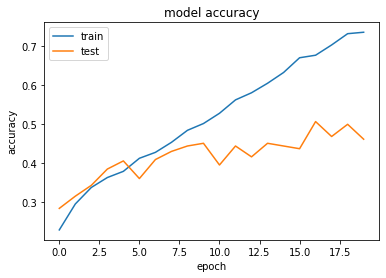

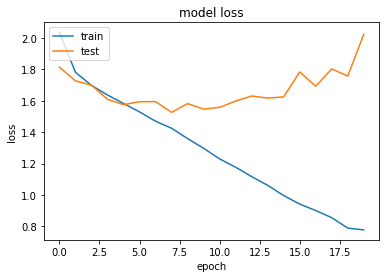

In [175]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [176]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,happy,happy
141,surprise,fear
142,happy,neutral
143,neutral,calm
144,sad,calm
145,sad,happy
146,calm,neutral
147,disgust,calm
148,calm,calm
149,fear,fear


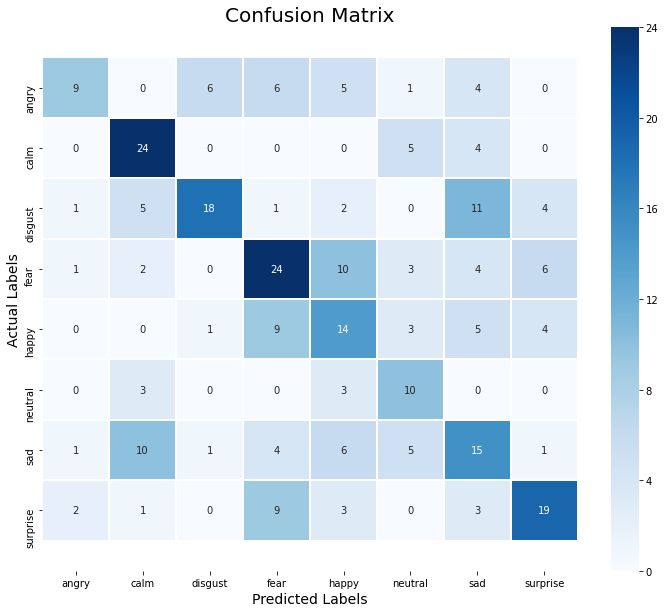

In [177]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [178]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.64      0.29      0.40        31
        calm       0.53      0.73      0.62        33
     disgust       0.69      0.43      0.53        42
        fear       0.45      0.48      0.47        50
       happy       0.33      0.39      0.35        36
     neutral       0.37      0.62      0.47        16
         sad       0.33      0.35      0.34        43
    surprise       0.56      0.51      0.54        37

    accuracy                           0.46       288
   macro avg       0.49      0.48      0.46       288
weighted avg       0.49      0.46      0.46       288



## Hyperparameter Tuning

In [ ]:
# STRATIFIED SHUFFLE SPLIT
X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
SSS = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in SSS.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# RESHAPE DATA TO 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [ ]:
# CREATE FUNCTION FOR KERAS CLASSIFIER
def make_classifier(optimizer='adam'):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.summary()
    opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [ ]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
model = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 32, 34],
    'nb_epoch': [50, 75, 100],
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)